In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
import mediapipe as mp
import logging
import re

In [2]:
def load_video(path:str) -> List[float]: 
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()
    print(f"Processing video: {path}")  # Print out the path of the video being processed
    cap = cv2.VideoCapture(path)
    frames=[]
    lips=[216, 430]
    try:
        for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
            ret, frame = cap.read()
            height, width, _ = frame.shape

            # Check if the input video is RGB, if not, convert it to RGB
            if frame.shape[2] != 3:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            result = face_mesh.process(frame)
            if result is not None and result.multi_face_landmarks:
                try:
                    for facial_landmarks in result.multi_face_landmarks:
                        x_max = 0
                        y_max = 0
                        x_min = width
                        y_min = height
                        for fl in lips:
                            pt1 = facial_landmarks.landmark[fl]
                            x, y = int(pt1.x * width), int(pt1.y * height)
                            if x > x_max:
                                x_max = x
                            if x < x_min:
                                x_min = x
                            if y > y_max:
                                y_max = y
                            if y < y_min:
                                y_min = y
                        gr = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                        cropped_frame = gr[y_min:y_max, x_min:x_max]
                        cropped_frame = cv2.resize(cropped_frame, (140, 46))
                        frames.append(cropped_frame)
                except Exception as t:
                    print(f"Error load_video at path {path}: {t}")
                    return None

    except Exception as e:
        print(f'Error processing video: {path}: {e}')  # Print out the error if any occurs during video processing
        return None
    finally:
        cap.release()
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std


In [3]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [4]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [5]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [6]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    match = re.search(r's(\d+)', path)
    number = match.group(1)

    global video_path
    video_path = os.path.join('data_grid_corpus',f's{number}',f'{file_name}.mpg')
    alignment_path = os.path.join('data_grid_corpus','alignments',f's{number}',f'{file_name}.align')
    try:
        frames = load_video(video_path)
        print("load_video() successful")
        alignments = load_alignments(alignment_path)
        print("load_alignments() successful")
        #alignments = char_to_num(tf.strings.unicode_split(alignments, input_encoding='UTF-8'))[1:]
        #print("alignment convert to tensor successful")
        print(f"Frames shape: {frames.shape}")
        print(f"Alignments shape: {alignments.shape}")
        return frames, alignments

    except Exception as e:
        print(f'Error load_data at path {path}: {e}')
        return None, None

In [7]:
test_path = '.\\data_grid_corpus\\s1\\bbaf3s.mpg'

In [8]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbaf3s'

In [9]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

Processing video: data_grid_corpus\s1\bbaf3s.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (24,)


In [10]:
load_data(tf.convert_to_tensor(test_path))

Processing video: data_grid_corpus\s1\bbaf3s.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (24,)


(<tf.Tensor: shape=(75, 46, 140), dtype=float32, numpy=
 array([[[ 0.25905952,  0.0518119 , -0.1036238 , ...,  0.5699309 ,
           0.51811904,  0.36268333],
         [ 0.36268333,  0.15543571, -0.1036238 , ...,  0.51811904,
           0.31087142,  0.2072476 ],
         [ 0.4144952 ,  0.2072476 , -0.0518119 , ...,  0.4144952 ,
           0.2072476 ,  0.1036238 ],
         ...,
         [ 1.0880499 ,  1.0362381 ,  1.0880499 , ...,  0.9326142 ,
           0.9326142 ,  0.88080233],
         [ 1.1916738 ,  1.1916738 ,  1.2434857 , ...,  0.88080233,
           0.8289904 ,  0.7771785 ],
         [ 1.2434857 ,  1.2434857 ,  1.2434857 , ...,  0.8289904 ,
           0.7771785 ,  0.72536665]],
 
        [[ 0.36268333, -0.1036238 , -0.31087142, ...,  0.51811904,
           0.51811904,  0.5699309 ],
         [ 0.4144952 , -0.1036238 , -0.36268333, ...,  0.51811904,
           0.51811904,  0.51811904],
         [ 0.4144952 , -0.0518119 , -0.4144952 , ...,  0.5699309 ,
           0.51811904,  0.51

In [11]:
video_path

'data_grid_corpus\\s1\\bbaf3s.mpg'

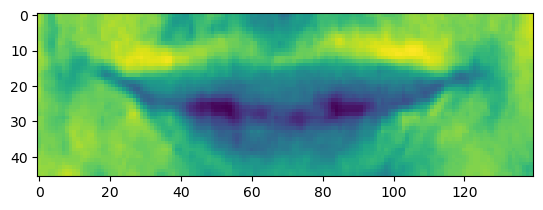

In [12]:
plt.imshow(frames[40])

In [13]:
tf.strings.reduce_join([num_to_char(align) for align in alignments], axis=-1)

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f three soon'>

In [14]:
def load_data_wrapper(path):
    def _load_data(path):
        frames, alignments = load_data(path)
        return frames, alignments
    
    frames, alignments = tf.py_function(_load_data, [path], [tf.float32, tf.int64])
    
    # If frames are None, return an empty tensor for frames and None for others
    if frames is None:
        return tf.constant([], dtype=tf.float32), None
    
    return frames, alignments

In [15]:
def filter_outliers(frames, alignments):
    # Filter out data where frames are empty
    return tf.size(frames) > 0

In [16]:
file_patterns=[]
speakers=[j for j in range(1,2) if j!=21]
for speaker_num in speakers:
    pattern = f"./data_grid_corpus/s{speaker_num}/*.mpg"
    file_patterns.append(pattern)

data = tf.data.Dataset.list_files(file_patterns)
data = data.shuffle(100, reshuffle_each_iteration=False)
data = data.map(load_data_wrapper)
data = data.filter(filter_outliers)
data = data.padded_batch(2, padded_shapes=([None,None,None],[None]))
data = data.prefetch(tf.data.AUTOTUNE)

# Added for split 
train = data.take(15)
test = data.skip(15)

In [17]:
frames, alignments = data.as_numpy_iterator().next()

Processing video: data_grid_corpus\s1\bbbm1s.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (22,)
Processing video: data_grid_corpus\s1\bbaf5a.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (24,)
Processing video: data_grid_corpus\s1\bbal7s.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (24,)


In [18]:
len(frames)

2

In [19]:
sample = data.as_numpy_iterator()

In [20]:
val = sample.next(); 
val[0]

Processing video: data_grid_corpus\s1\bbaz7a.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (25,)
Processing video: data_grid_corpus\s1\bbas2p.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (24,)


array([[[[1.1504914 , 1.10047   , 1.0004272 , ..., 1.0004272 ,
          1.0504487 , 1.0504487 ],
         [1.1504914 , 1.0504487 , 0.9003845 , ..., 1.0504487 ,
          1.0504487 , 1.0504487 ],
         [1.1504914 , 1.0504487 , 0.85036314, ..., 1.0504487 ,
          1.0504487 , 1.0504487 ],
         ...,
         [0.85036314, 0.85036314, 0.75032043, ..., 0.550235  ,
          0.550235  , 0.550235  ],
         [0.85036314, 0.85036314, 0.8003418 , ..., 0.550235  ,
          0.550235  , 0.550235  ],
         [0.85036314, 0.85036314, 0.8003418 , ..., 0.6002563 ,
          0.6002563 , 0.6002563 ]],

        [[1.10047   , 0.9003845 , 0.9003845 , ..., 0.9504059 ,
          1.0004272 , 1.0004272 ],
         [1.0504487 , 0.9003845 , 0.85036314, ..., 0.9504059 ,
          1.0004272 , 1.0004272 ],
         [1.0504487 , 0.9003845 , 0.8003418 , ..., 0.9504059 ,
          1.0004272 , 1.0504487 ],
         ...,
         [0.8003418 , 0.7002991 , 0.6002563 , ..., 0.6002563 ,
          0.6002563 , 0.6

Processing video: data_grid_corpus\s1\bbas1s.mpg


In [21]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [-2.2509613037109375, 1.500640869140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.2509613037109375, 1.7007262706756592]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.200939893722534, 1.7507476806640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.4010252952575684, 1.6507049798965454]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.501068115234375, 1.7007262706756592]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.4010252952575684, 1.7007262706756592]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.4010252952575684, 1.700726270

Lossy conversion from float32 to uint8. Range [-2.7511749267578125, 1.7507476806640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.7511749267578125, 1.7007262706756592]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.651132106781006, 1.7007262706756592]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.651132106781006, 1.7507476806640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.651132106781006, 1.7507476806640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.6011109352111816, 1.7007262706756592]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.6011109352111816, 1.750747680

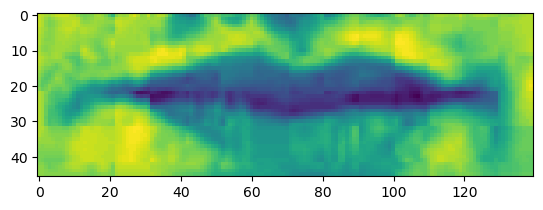

In [22]:
plt.imshow(val[0][0][0])

In [23]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at z seven again'>

In [24]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, GRU, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [25]:
data.as_numpy_iterator().next()[0][0].shape

Processing video: data_grid_corpus\s1\bbas1s.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (22,)
Processing video: data_grid_corpus\s1\bbaf2n.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (22,)
Processing video: data_grid_corpus\s1\bbas2p.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (21,)
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (24,)
Processing video: data_grid_corpus\s1\bbal6n.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (21,)


(75, 46, 140)

In [26]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(None,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, None, 46, 140, 1   3584      
                             28)                                 
                                                                 
 activation (Activation)     (None, None, 46, 140, 1   0         
                             28)                                 
                                                                 
 max_pooling3d (MaxPooling3  (None, None, 23, 70, 12   0         
 D)                          8)                                  
                                                                 
 conv3d_1 (Conv3D)           (None, None, 23, 70, 25   884992    
                             6)                                  
                                                                 
 activation_1 (Activation)   (None, None, 23, 70, 25   0

In [28]:
yhat = model.predict(val[0])

1/1 [==============================] - 17s 17s/step


In [29]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'jeeeddddddddddddddddddddddddddddddeeedddddddddddddddddddddddddddddddeeeedgg'>

In [30]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'jeeeddddddddddddddddddddddddddddddeeedddddddddddddddddddddddddddddddeeeedgg'>

In [31]:
model.input_shape

(None, None, 46, 140, 1)

In [32]:
model.output_shape

(None, None, 41)

In [33]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [34]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [35]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, input_length=np.ones(yhat.shape[0])*yhat.shape[1], greedy=True)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [36]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [40]:
checkpoint_callback = ModelCheckpoint(os.path.join('check_test','checkpoint'), monitor='loss', save_weights_only=True) 

In [41]:
schedule_callback = LearningRateScheduler(scheduler)

In [42]:
example_callback = ProduceExample(test)

In [43]:
model.fit(train , validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Processing video: data_grid_corpus\s1\bbbf6n.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (21,)
Processing video: data_grid_corpus\s1\bbal6n.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (21,)
Processing video: data_grid_corpus\s1\bbal9a.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (24,)
Processing video: data_grid_corpus\s1\bbaf3s.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (24,)
Processing video: data_grid_corpus\s1\bbaf2n.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (21,)
Processing video: data_grid_corpus\s1\bbas3a.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (25,)
Processing video: data_grid_corpus\s1\bbal8p.mpg
load_video() successful
loa

Processing video: data_grid_corpus\s1\bbbmzn.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (22,)
Processing video: data_grid_corpus\s1\bbal9a.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (24,)
Processing video: data_grid_corpus\s1\bbaz4n.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (22,)
Processing video: data_grid_corpus\s1\bbas1s.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (22,)
Processing video: data_grid_corpus\s1\bbal6n.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (21,)
Processing video: data_grid_corpus\s1\bbaz7a.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (25,)
Processing video: data_grid_corpus\s1\bbas3a.mpg
load_video() successful
loa

StopIteration: 

In [37]:
#model.load_weights('check_test/checkpoint')
model.load_weights('high_models/checkpoints1_7.h5')

In [51]:
test_data = test.as_numpy_iterator()

In [49]:
sample = test_data.next()

Processing video: high_data\s1\bbas1s.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (22,)
Processing video: high_data\s1\bbbf7s.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (24,)
Processing video: high_data\s1\bbaz7a.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (25,)
Processing video: high_data\s1\bbbf5n.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (22,)
Processing video: high_data\s1\bbaszs.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (23,)
Processing video: high_data\s1\bbbf8p.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (26,)
Processing video: high_data\s1\bbaf3p.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 

In [50]:
yhat = model.predict(sample[0])

1/1 [==============================] - 12s 12s/step


In [51]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by l nine now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at s three again'>]

In [52]:
input_len = np.ones(yhat.shape[0]) * yhat.shape[1]
decoded = tf.keras.backend.ctc_decode(yhat, input_length=input_len, greedy=True)[0][0]

In [53]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b''>,
 <tf.Tensor: shape=(), dtype=string, numpy=b''>]

In [38]:
#sample = load_data(tf.convert_to_tensor('.\\high_data\\s1\\bbbf5n.mpg'))
sample = load_data(tf.convert_to_tensor('.\\high_data\\s1\\bbaf5a.mpg'))

Processing video: data_grid_corpus\s1\bbaf5a.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (24,)


In [39]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f five again'>]

In [40]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 11s 11s/step


In [41]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'binbbluuee  wwy           ffffivvv   aaaiin'>

In [42]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=np.ones(yhat.shape[0])*yhat.shape[1], greedy=True)[0][0].numpy()


In [43]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'binblue wy fiv ain'>]

In [ ]:
#pbbv6n lwbf5a pgbe5a swiozn

In [ ]:
#Metrics

In [45]:
!pip install python-Levenshtein

   ---------------------------------------- 0.0/98.4 kB ? eta -:--:--
   ---------------------------------------- 98.4/98.4 kB 5.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.7 MB 6.5 MB/s eta 0:00:01
   -------------- ------------------------- 0.6/1.7 MB 7.5 MB/s eta 0:00:01
   ---------------- ----------------------- 0.7/1.7 MB 4.9 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 4.3 MB/s eta 0:00:01
   ------------------- -------------------- 0.8/1.7 MB 3.7 MB/s eta 0:00:01
   ---------------------- ----------------- 0.9/1.7 MB 3.3 MB/s eta 0:00:01
   ----------------------- ---------------- 1.0/1.7 MB 3.3 MB/s eta 0:00:01
   -------------------------- ------------- 1.1/1.7 MB 2.9 MB/s eta 0:00:01
   ---------------------------- ----------- 1.2/1.7 MB 2.7 MB/s eta 0:00:01
   ----------------------------- ---------- 1.2/1.7 MB 2.6 MB/s eta 0:00:01
   --------------------


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
import Levenshtein as lev

def character_error_rate(y_true, y_pred):
    cer = np.mean([lev.distance(y_true[i], y_pred[i]) for i in range(len(y_true))])
    return cer

def word_error_rate(y_true, y_pred):
    wer = np.mean([lev.distance(y_true[i].split(), y_pred[i].split()) for i in range(len(y_true))])
    return wer

In [53]:
y_pred = model.predict(test_data)
y_true = [transcript for _, transcript in test_data] 

cer = character_error_rate(y_true, y_pred)
wer = word_error_rate(y_true, y_pred)

print("Character Error Rate (CER):", cer)
print("Word Error Rate (WER):", wer)

Processing video: high_data\s1\bbbm1s.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (22,)
Processing video: high_data\s1\bbal7p.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (26,)
Processing video: high_data\s1\bbar9n.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (22,)
Processing video: high_data\s1\bbal6n.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (21,)
Processing video: high_data\s1\bbbf9a.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (24,)
Processing video: high_data\s1\bbbf7p.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 140)
Alignments shape: (26,)
Processing video: high_data\s1\bbas3a.mpg
load_video() successful
load_alignments() successful
Frames shape: (75, 46, 

In [1]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       2.0.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
altair                        5.1.2
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.3
anaconda-navigator            2.5.0
anaconda-project              0.11.1
analytics-python              1.4.post1
annotated-types               0.6.0
anyio                         3.7.1
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunp


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
